In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sqlalchemy
import datetime as dt

In [2]:
#load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

## Tables

In [3]:
# Create database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')


In [4]:
def create_df(table_name):
    try:
        connection = engine.connect() # Connect to the database
        query = f'''
        SELECT 
            *
        FROM
            {table_name} 
        '''
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback()  # Rollback in case of error
    finally:
        connection.close()  # Close the connection

In [5]:
online_sales = create_df('online_sales')
online_sales

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct
0,17850,16679,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
1,17850,16680,2019-01-01,B09DL9978Y,1,6.50,Used,ELEC10,0.1
2,17850,16681,2019-01-01,B07GXHC691,1,6.50,Used,OFF10,0.1
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.50,Not Used,SALE10,0.1
4,17850,16682,2019-01-01,B08H21B6V7,1,6.50,Used,AIO10,0.1
...,...,...,...,...,...,...,...,...,...
53696,14410,48493,2019-12-31,B07XLML2YS,1,6.50,Not Used,ELEC30,0.3
53697,14410,48494,2019-12-31,B09WN3SRC7,1,6.50,Used,SALE30,0.3
53698,14410,48495,2019-12-31,B07VX71FZP,1,6.50,Used,ELEC30,0.3
53699,14600,48496,2019-12-31,B00Y4ORQ46,5,6.50,Not Used,ELEC30,0.3


In [6]:
# get products table

products = create_df('products')
products

,product_id,product_name,about_product,category,actual_price,discounted_price,discount_percentage,origin_area
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,High Compatibility : Compatible With iPhone 12...,Computers&Accessories|Accessories&Peripherals|...,13.19,4.79,0.64,"Dongguan, China"
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,"Compatible with all Type C enabled devices, be...",Computers&Accessories|Accessories&Peripherals|...,4.19,2.39,0.43,"Ningbo, China"
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,【 Fast Charger& Data Sync】-With built-in safet...,Computers&Accessories|Accessories&Peripherals|...,22.79,2.39,0.90,"Shanghai, China"
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,The boAt Deuce USB 300 2 in 1 cable is compati...,Computers&Accessories|Accessories&Peripherals|...,8.39,3.95,0.53,"Dongguan, China"
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Computers&Accessories|Accessories&Peripherals|...,4.79,1.85,0.61,"Ningbo, China"
...,...,...,...,...,...,...,...,...
1346,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,11.03,4.55,0.59,"Hefei, China"
1347,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,"230 Volts, 400 watts, 1 Year",Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,36.54,27.36,0.25,"Dongguan, China"
1348,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,International design and styling|Two heat sett...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",36.96,26.63,0.28,"Shenzhen, China"
1349,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,Fan sweep area: 230 MM ; Noise level: (40 - 45...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",22.68,16.79,0.26,"Higashiomi-shi, Japan"


In [7]:
# get ratings table

ratings = create_df('ratings')
ratings

,product_id,average_rating,review_title,review_content,rating_count
0,B002PD61Y4,4.1,"good tool to use for,Brand is always good,Over...",good quality tool from d linkWiFi signal is go...,16262
1,B002SZEOLG,4.2,Works on linux for me. Get the model with ante...,I use this to connect an old PC to internet. I...,179692
2,B003B00484,4.3,"Works Good,Perfect replacement cell for trimme...","Works good,Bought it to replace my Phillips QT...",27201
3,B003L62T7W,4.3,"Handy Mouse,Good quality mouse,Good one.,Good,...","Liked this Product,https://m.media-amazon.com/...",31534
4,B004IO5BMQ,4.5,"Good silent mouse,Too small to hold!,Reviewing...",It's little small for big hands. But best avai...,54405
...,...,...,...,...,...
1346,B0BPCJM7TB,4.0,"Nice frother,Nice product I like this product,...",This is my first coffee frother and I just lov...,43
1347,B0BPJBTB3F,2.0,"Bad quality,Amazing product..",The heating capacity is zero .Moreover i have ...,2
1348,B0BQ3K23Y1,4.8,"Oratech Best Coffee Frother,Great,My review ab...","Overall, I love this Oratech Coffee frother an...",28
1349,B0BQRJ3C47,5.0,Awesome Product,Quick delivery.Awesome ProductPacking was good...,0


In [8]:
# get users table

users = create_df('users')
users

,user_id,age,gender
0,1,23,Female
1,2,23,Female
2,3,24,Prefer not to say
3,4,24,Female
4,5,22,Female
...,...,...,...
2065,14438,57,Female
2066,12956,60,Female
2067,15781,55,Male
2068,14410,19,Female


## Part 1: Analyze historical sales data

### EDA

In [9]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           53701 non-null  int64         
 1   transaction_id    53701 non-null  int64         
 2   date              53701 non-null  datetime64[ns]
 3   product_id        53701 non-null  object        
 4   Quantity          53701 non-null  int64         
 5   Delivery_Charges  53701 non-null  float64       
 6   Coupon_Status     53701 non-null  object        
 7   Coupon_Code       53701 non-null  object        
 8   Discount_pct      53701 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 3.7+ MB


In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1351 non-null   object 
 1   product_name         1351 non-null   object 
 2   about_product        1351 non-null   object 
 3   category             1351 non-null   object 
 4   actual_price         1351 non-null   float64
 5   discounted_price     1351 non-null   float64
 6   discount_percentage  1351 non-null   float64
 7   origin_area          1351 non-null   object 
dtypes: float64(3), object(5)
memory usage: 84.6+ KB


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      1351 non-null   object 
 1   average_rating  1351 non-null   float64
 2   review_title    1351 non-null   object 
 3   review_content  1351 non-null   object 
 4   rating_count    1351 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 52.9+ KB


In [12]:
# Join online_sales, users, products and ratings tables
historical_sales = online_sales.copy()
historical_sales = pd.merge(historical_sales, users, on='user_id', how='inner')
historical_sales = pd.merge(historical_sales, products, on='product_id', how='inner')
historical_sales = pd.merge(historical_sales, ratings, on='product_id', how='inner')
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,about_product,category,actual_price,discounted_price,discount_percentage,origin_area,average_rating,review_title,review_content,rating_count
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,"Huizhou, China",4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,Stainless Steel Tank|Copper Heating element|IS...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,"Huizhou, China",4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,"[PORTABLE SIZE]- 98mm*96mm*19mm, STRIFF desk p...",Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,"Guangzhou, China",4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,"2 years warranty from the date of purchase, yo...",Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,"Shenzhen, China",4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,MicroSD card slot expandable up to 32. Network...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,"Taichung City, Taiwan",3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266


In [13]:
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53701 non-null  int64         
 1   transaction_id       53701 non-null  int64         
 2   date                 53701 non-null  datetime64[ns]
 3   product_id           53701 non-null  object        
 4   Quantity             53701 non-null  int64         
 5   Delivery_Charges     53701 non-null  float64       
 6   Coupon_Status        53701 non-null  object        
 7   Coupon_Code          53701 non-null  object        
 8   Discount_pct         53701 non-null  float64       
 9   age                  53701 non-null  int64         
 10  gender               53701 non-null  object        
 11  product_name         53701 non-null  object        
 12  about_product        53701 non-null  object        
 13  category             53701 non-

Create a total_price column where total_price = discounted_price x quantity if the Coupon_Status was used, and total_price = actual_price x quantity otherwise. In this case, a Clicked Coupon_Status means that a customer tried to use the coupon but it was not applicable to the product.

In [14]:
historical_sales['total_price'] = np.where(
    historical_sales['Coupon_Status'] == 'Used',
    historical_sales['Quantity'] * historical_sales['actual_price'] * (1 - historical_sales['Discount_pct']),
    historical_sales['Quantity'] * historical_sales['actual_price']
)
historical_sales.head()

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,category,actual_price,discounted_price,discount_percentage,origin_area,average_rating,review_title,review_content,rating_count,total_price
0,17850,16679,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,"Huizhou, China",4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,49.572
1,17850,16680,2019-01-01,B09DL9978Y,1,6.5,Used,ELEC10,0.1,33,...,"Home&Kitchen|Heating,Cooling&AirQuality|WaterH...",55.08,28.79,0.48,"Huizhou, China",4.1,"Good heater, and delivery and installation was...",The instant heater was well made. And works we...,444,49.572
2,17850,16681,2019-01-01,B07GXHC691,1,6.5,Used,OFF10,0.1,33,...,Electronics|Mobiles&Accessories|MobileAccessor...,5.99,1.19,0.80,"Guangzhou, China",4.3,"Good Stand For Mobiles !,Nice produt,Useful,Af...",This is good mobile stand. Sturdy with mobiles...,42641,5.391
3,17850,16682,2019-01-01,B08NCKT9FG,5,6.5,Not Used,SALE10,0.1,33,...,Computers&Accessories|Accessories&Peripherals|...,9.58,3.59,0.63,"Shenzhen, China",4.4,"Good Stuff... Recommended!!!,Need better quali...","Good Stuff... Recommended!!!,Need better quali...",28791,47.900
4,17850,16682,2019-01-01,B08H21B6V7,1,6.5,Used,AIO10,0.1,33,...,Electronics|Mobiles&Accessories|Smartphones&Ba...,35.99,31.19,0.13,"Taichung City, Taiwan",3.9,"Ok phone,Good Basic Phone,Nice one,Hghjk,Good ...",Audio contains lots of distortion when using s...,14266,32.391


In [15]:
# rename category to subcategory
# create new column "category" which serves as the overall category for each product
historical_sales.rename(columns={'category':'subcategory'}, inplace=True)
historical_sales['category'] = historical_sales['subcategory'].apply(lambda x: str.split(x, sep='|')[0])
historical_sales['category'].value_counts()

category
Electronics              26748
Home&Kitchen             14162
Computers&Accessories    10643
OfficeProducts            2121
MusicalInstruments          27
Name: count, dtype: int64

#### Ratings analysis

In [16]:
historical_sales_by_product = historical_sales.drop_duplicates(subset='product_id')
historical_sales_by_product.shape

(133, 24)

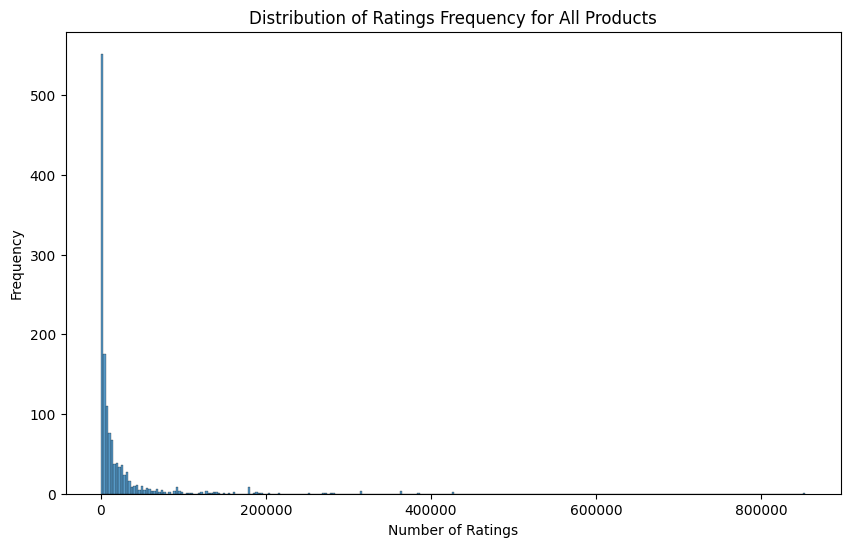

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(data=ratings, x="rating_count")
plt.title("Distribution of Ratings Frequency for All Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

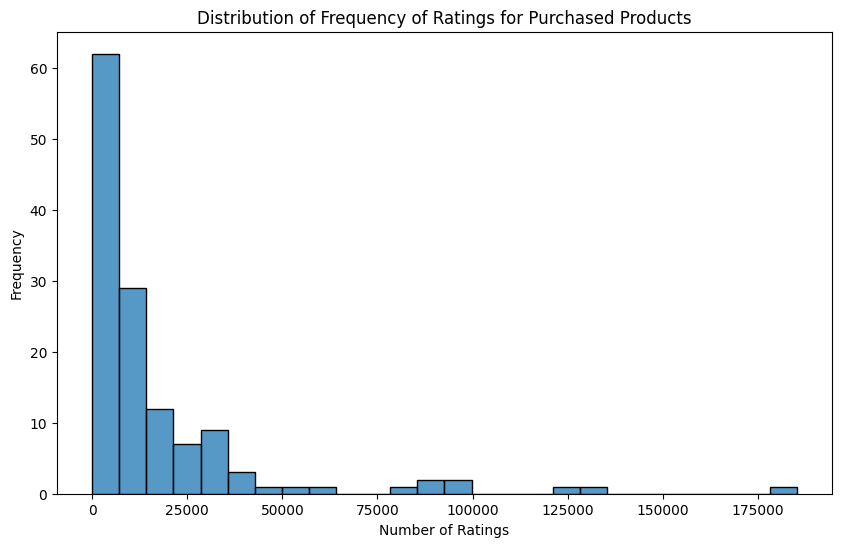

In [18]:
plt.figure(figsize=(10,6))
sns.histplot(data=historical_sales_by_product, x="rating_count")
plt.title("Distribution of Frequency of Ratings for Purchased Products")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

In [19]:
print(f"Number of products with less than 1000 ratings: {historical_sales_by_product[historical_sales_by_product['rating_count']<1000].shape[0]}")

Number of products with less than 1000 ratings: 30


Even though the ratings frequency is heavily right skewed with some outliers, majority of the products still have a review of at least a thousand, which can give insightful feedback to potential buyers.

#### Coupon and Discount percentage analysis

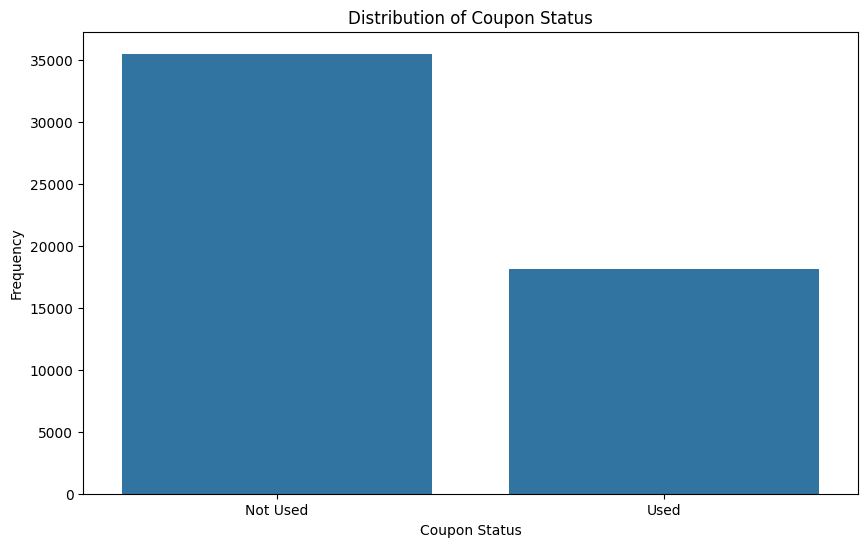

In [20]:
historical_sales_coupon = historical_sales['Coupon_Status'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=historical_sales_coupon.index, y=historical_sales_coupon.values)
plt.title("Distribution of Coupon Status")
plt.xlabel("Coupon Status")
plt.ylabel("Frequency")
plt.show()

Majority of the coupons were not used. This could indicate uncertainty that customers may not be aware of the coupons available to the product and could be an area of improvement for the platform. 

Text(0.5, 0, 'Discount Percentage')

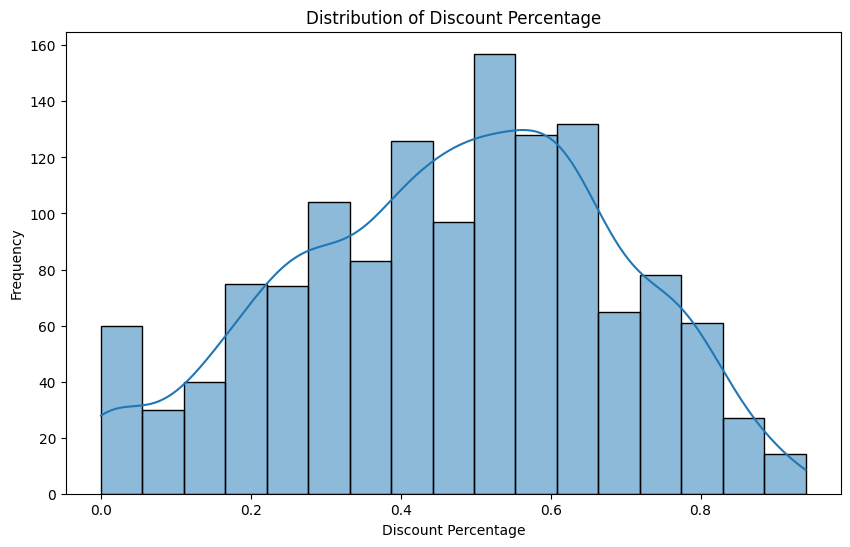

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(products, x='discount_percentage', kde=True)
plt.title("Distribution of Discount Percentage")
plt.ylabel("Frequency")
plt.xlabel("Discount Percentage")

The discount percentage generally follows a normal distribution with the exception of a slight right skew. However, this is to be expected as not all products will have a discount applied to them.

Text(0.5, 1.0, 'Scatter plot of Actual Price against Discount Percentage')

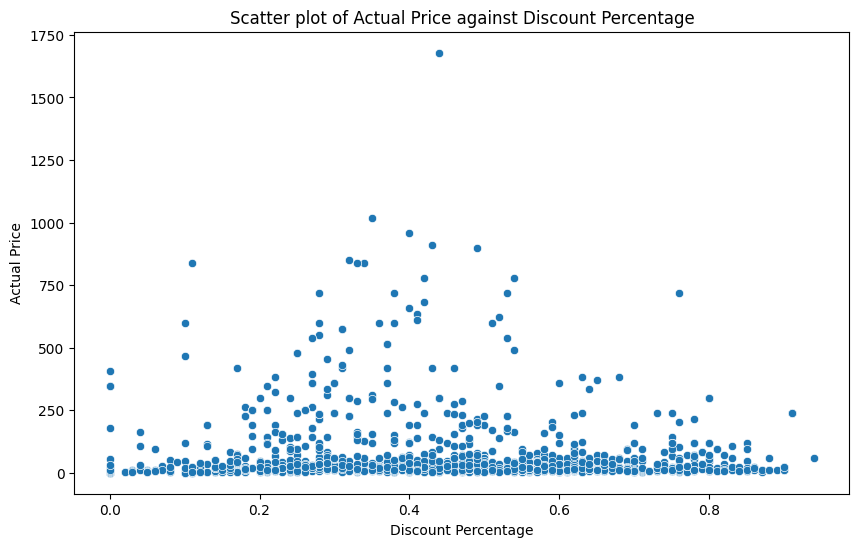

In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(products, x='discount_percentage', y='actual_price')
plt.ylabel('Actual Price')
plt.xlabel('Discount Percentage')
plt.title('Scatter plot of Actual Price against Discount Percentage')

There is no strong correlation between actual price and discount percedntage, especially when the actual price is below USD 125.

#### Historical sales analysis

In [23]:
# Aggregate by day
daily_sales = historical_sales.groupby(historical_sales['date'].dt.date).agg(total_sales=('total_price', 'sum')).reset_index()

# Aggregate by month
monthly_sales = historical_sales.groupby(historical_sales['date'].dt.to_period('M')).agg(total_sales=('total_price', 'sum')).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales

,date,total_sales
0,2019-01-01,2090741.777
1,2019-02-01,2192522.426
2,2019-03-01,2659384.807
3,2019-04-01,2981351.091
4,2019-05-01,2381874.934
5,2019-06-01,2110479.086
6,2019-07-01,3593721.573
7,2019-08-01,3061509.246
8,2019-09-01,2954247.391
9,2019-10-01,2538036.488


In [24]:
daily_sales

,date,total_sales
0,2019-01-01,24329.353
1,2019-01-02,23028.136
2,2019-01-03,136089.338
3,2019-01-04,136099.221
4,2019-01-05,163550.181
...,...,...
360,2019-12-27,75004.199
361,2019-12-28,11459.726
362,2019-12-29,19357.553
363,2019-12-30,16245.191


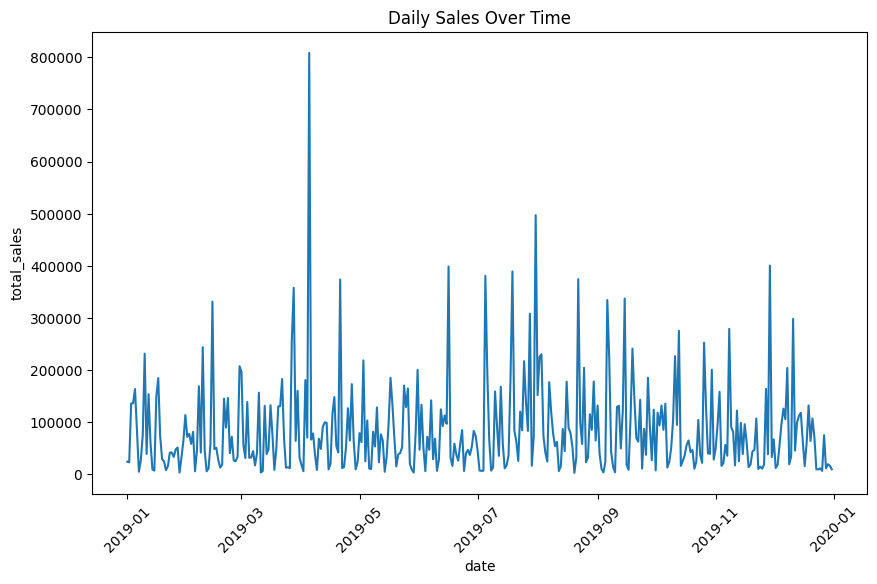

In [25]:
# Plot daily sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=daily_sales)
plt.title('Daily Sales Over Time')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Transactions where total sales are above USD 200,000
historical_sales[historical_sales['total_price'] > 200000]

,user_id,transaction_id,date,product_id,Quantity,Delivery_Charges,Coupon_Status,Coupon_Code,Discount_pct,age,...,actual_price,discounted_price,discount_percentage,origin_area,average_rating,review_title,review_content,rating_count,total_price,category
11394,13842,24286,2019-03-28,B09WN3SRC7,140,250.01,Not Used,OFF30,0.3,52,...,1678.80,935.88,0.44,"Dongguan, China",4.7,Product installation was excellent but delive...,The delivery people were not careful with the ...,5935,235032.0,Electronics
12393,13113,24863,2019-04-05,B0B9XLX8VR,750,6.50,Used,EXTRA10,0.1,29,...,780.00,455.99,0.42,"Shanghai, China",4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,526500.0,Electronics
23073,14621,30550,2019-06-16,B0B9XLX8VR,475,6.00,Not Used,EXTRA30,0.3,31,...,780.00,455.99,0.42,"Shanghai, China",4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,370500.0,Electronics
30268,13081,34193,2019-07-31,B0B9XLX8VR,500,12.99,Not Used,EXTRA10,0.1,18,...,780.00,455.99,0.42,"Shanghai, China",4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,390000.0,Electronics
34786,13488,36323,2019-08-22,B0B9XLX8VR,300,50.93,Not Used,OFF20,0.2,57,...,780.00,455.99,0.42,"Shanghai, China",4.3,Good TV for the price. (But my experience was ...,",Screen quality is good.It's been a month I bo...",3587,234000.0,Electronics
48974,15144,45142,2019-11-29,B0B2RBP83P,475,504.00,Not Used,OFF20,0.2,25,...,718.68,446.96,0.38,"Mianyang, China",4.0,"Value for money laptop for normal usage,Works ...",If you are looking for a decent laptop and res...,323,341373.0,Computers&Accessories


There are several transactions with exceptionally high total_price due to the high quantity and high actual_price. It is possible that these purchases may be from big organisations who are bulk buying these products and they may regularly obtain their electronic needs from Amazon.

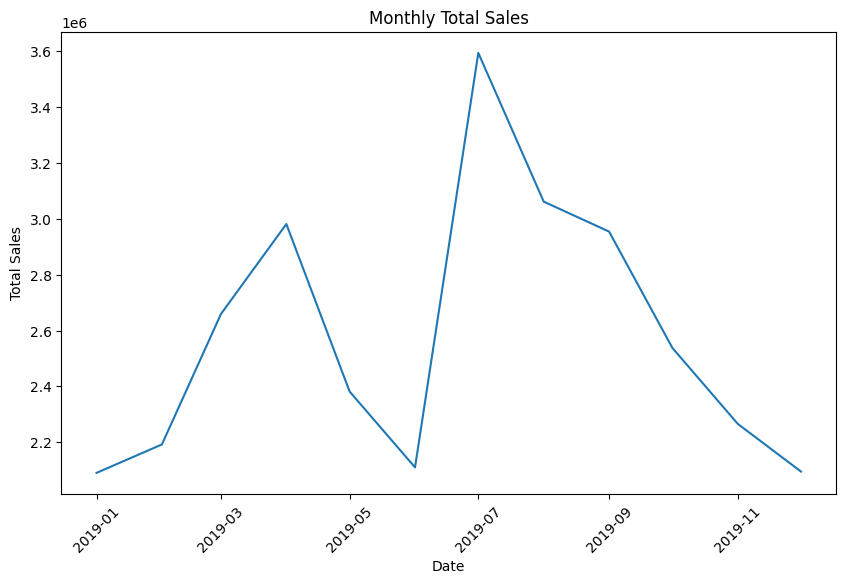

In [27]:
# Plot monthly total sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', data=monthly_sales)
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Aggregate total sales by month and category
monthly_sales_by_category = historical_sales.groupby([historical_sales['date'].dt.to_period('M'), historical_sales['category']]).agg(total_sales=('total_price', 'sum')).reset_index()
monthly_sales_by_category['date'] = monthly_sales_by_category['date'].dt.to_timestamp()
monthly_sales_by_category.head()

,date,category,total_sales
0,2019-01-01,Computers&Accessories,351128.597
1,2019-01-01,Electronics,1583823.326
2,2019-01-01,Home&Kitchen,149302.129
3,2019-01-01,OfficeProducts,6487.725
4,2019-02-01,Computers&Accessories,300115.320


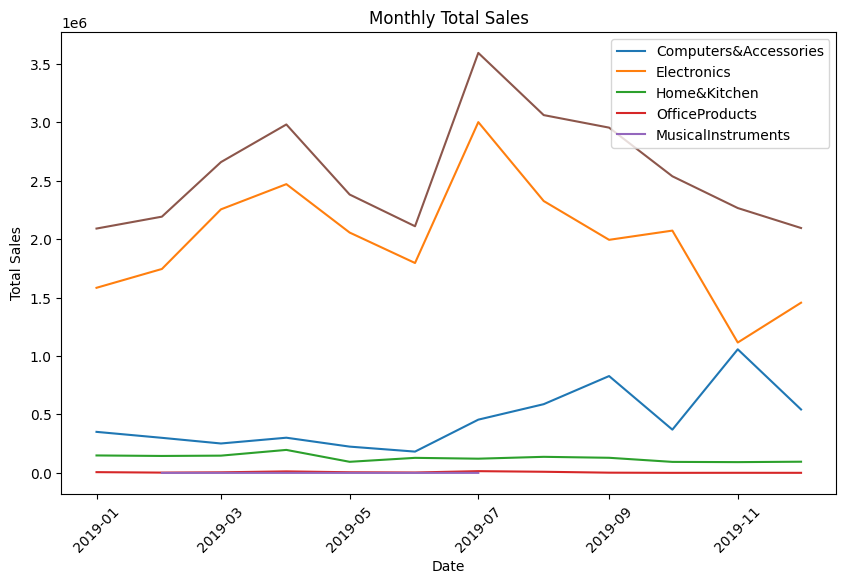

In [29]:
# Plot monthly total sales
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='total_sales', hue='category', data=monthly_sales_by_category)
sns.lineplot(x='date', y='total_sales', data=monthly_sales)
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

There is a peak in total sales in the July which decreases towards the end of the year. However, it is hard to determine if this is a pattern as we only have one year's worth, of data.  
Excluding the month of November, we see sales peaking in March, April, June, July and August which coincides with the exceptionally large transactions previously.

We also see that the major contributor of sales comes from products under the "Electronics" category and the two lines generally follow the same trend except from September onwards where they become inversely related.

In [30]:
# Total sales by category
top_products = historical_sales.groupby('category').agg(total_sales=('total_price', 'sum')).reset_index()

# Sort by total sales
top_products = top_products.sort_values(by='total_sales', ascending=False).head()
top_products

,category,total_sales
1,Electronics,2.387399e+07
0,Computers&Accessories,5.453826e+06
2,Home&Kitchen,1.533027e+06
4,OfficeProducts,6.433558e+04
3,MusicalInstruments,2.416320e+02


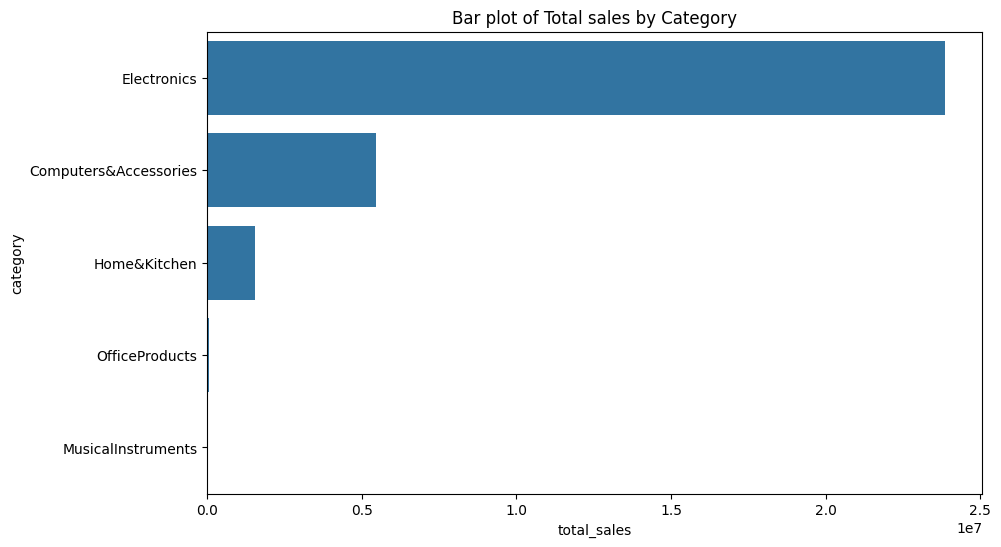

In [31]:
# Bar plot of top sales by Category
plt.figure(figsize=(10,6))
sns.barplot(x='total_sales', y='category', data=top_products)
plt.title('Bar plot of Total sales by Category')
plt.show()


In [32]:
# Total sales by product
top_products = historical_sales.groupby('product_name').agg(total_sales=('total_price', 'sum')).reset_index()

# Sort by total sales
top_products = top_products.sort_values(by='total_sales', ascending=False).head(10)


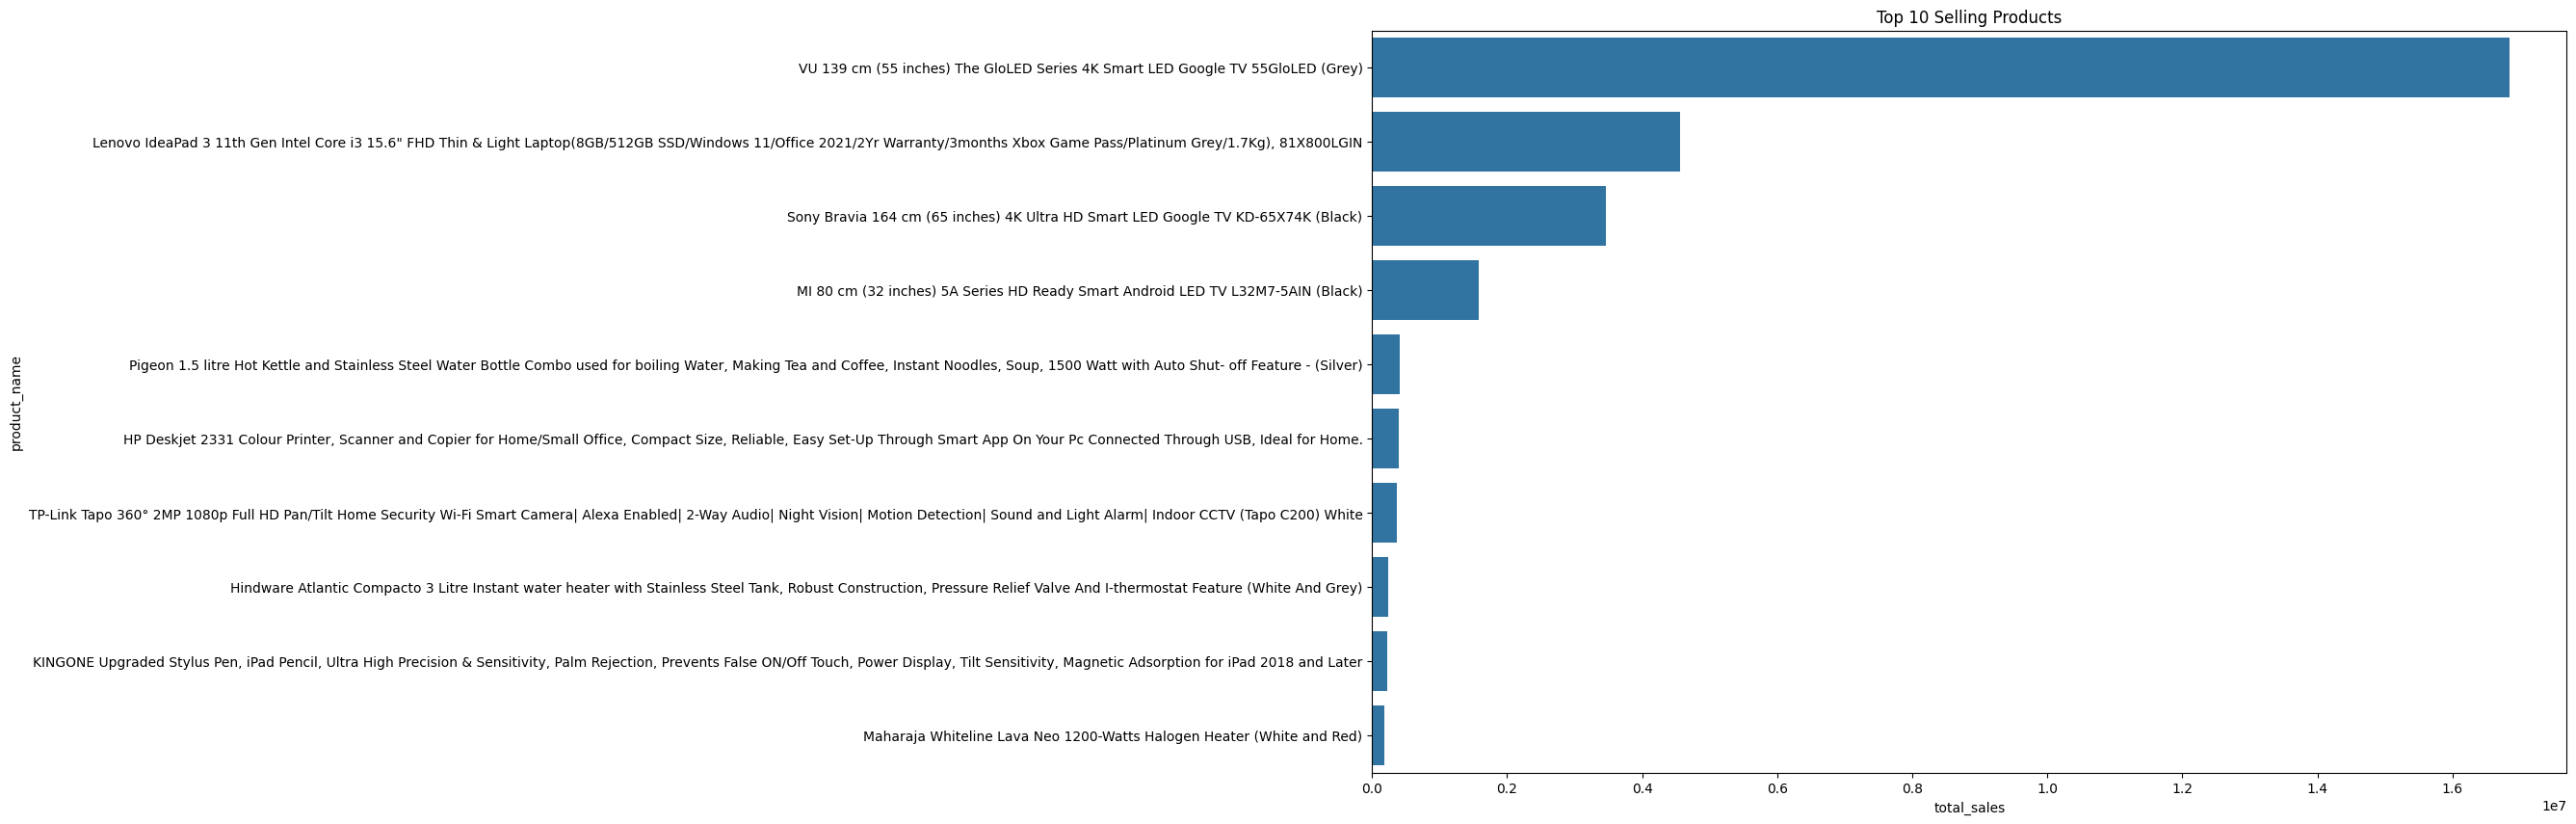

In [33]:
# Bar plot of top 10 products
plt.figure(figsize=(16,10))
sns.barplot(x='total_sales', y='product_name', data=top_products)
plt.title('Top 10 Selling Products')
plt.show()


We see that a large marjority of the total sales is contributed by the 'Electronics' category followed by the 'Computers&Accessories' category and coincides with the top 10 selling products.

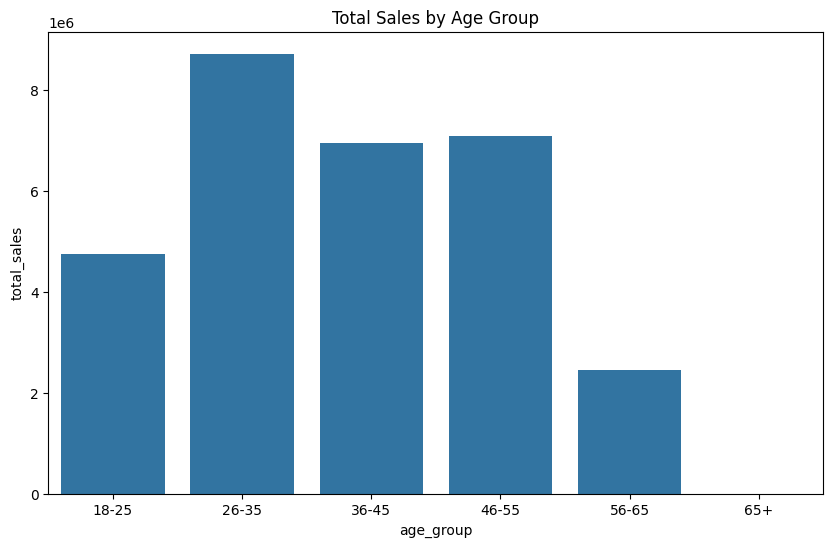

In [34]:
# Creating age bins
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
historical_sales['age_group'] = pd.cut(historical_sales['age'], bins=bins, labels=labels)

# Aggregate sales by age group
age_group_sales = historical_sales.groupby('age_group').agg(total_sales=('total_price', 'sum')).reset_index()

# Bar plot of sales by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='total_sales', data=age_group_sales)
plt.title('Total Sales by Age Group')
plt.show()


People aged 26-35 spend the most online.

   gender   total_sales
0  Female  1.504795e+07
1    Male  1.587748e+07


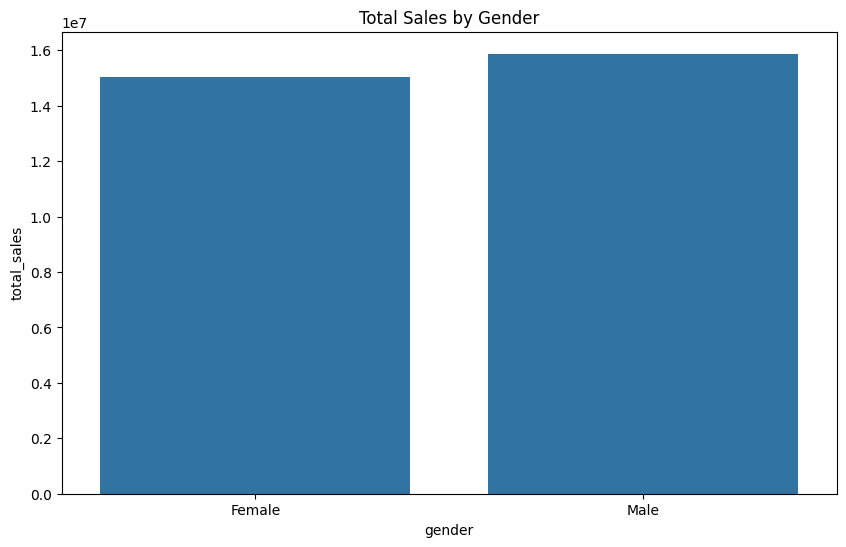

In [35]:
# Total sales by gender
gender_sales = historical_sales.groupby('gender').agg(total_sales=('total_price', 'sum')).reset_index()
print(gender_sales)
# Bar plot of sales by gender
plt.figure(figsize=(10,6))
sns.barplot(x='gender', y='total_sales', data=gender_sales)
plt.title('Total Sales by Gender')
plt.show()


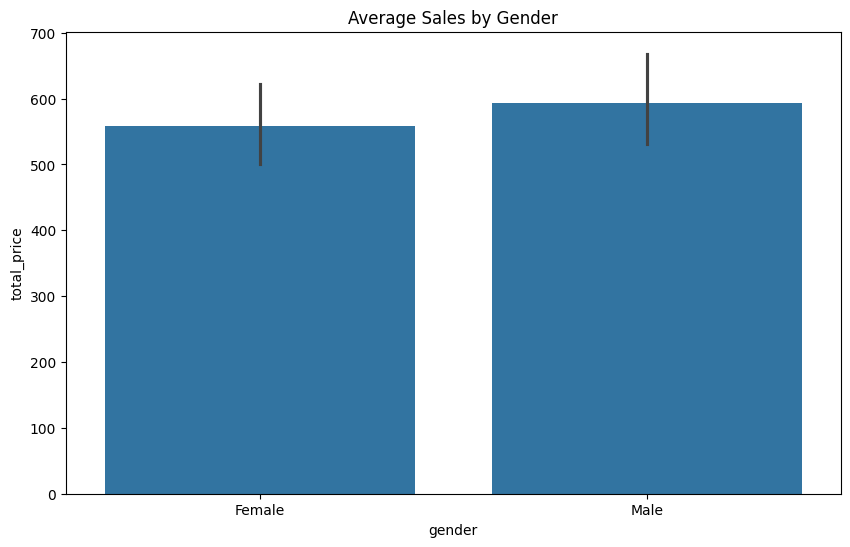

In [36]:
# average sales by gender
plt.figure(figsize=(10,6))
sns.barplot(x='gender', y='total_price', data=historical_sales)
plt.title('Average Sales by Gender')
plt.show()

Males tend to spend slightly more than females on average.

type
repeat      1402
one-time      66
Name: count, dtype: int64


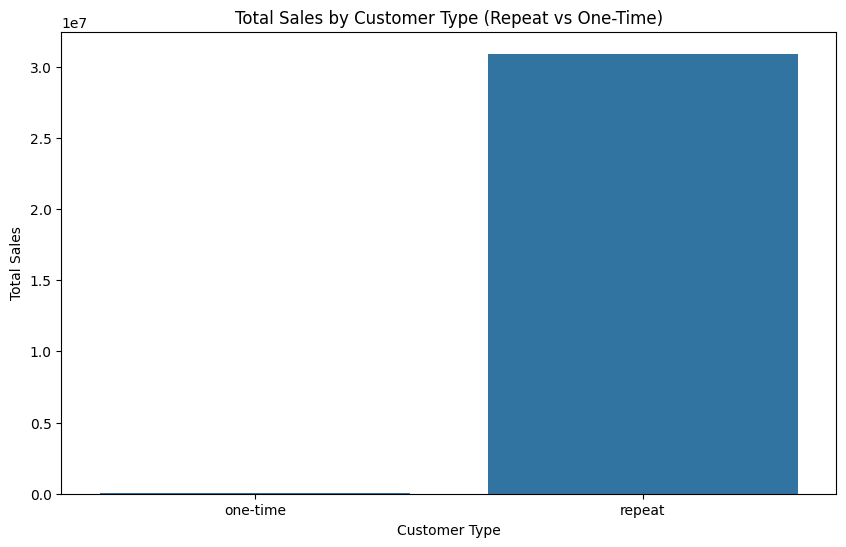

In [37]:
# Count the number of purchases per customer
customer_type = historical_sales.groupby('user_id').agg(total_orders=('transaction_id', 'count')).reset_index()
# Classify customers as 'repeat' or 'one-time'
customer_type['type'] = customer_type['total_orders'].apply(lambda x: 'repeat' if x > 1 else 'one-time')

# Aggregate sales by customer type
customer_type_sales = pd.merge(historical_sales, customer_type[['user_id', 'type']], on='user_id')
customer_type_sales = customer_type_sales.groupby('type').agg(total_sales=('total_price', 'sum')).reset_index()
print(customer_type['type'].value_counts())

# Plot sales by customer type
plt.figure(figsize=(10,6))
sns.barplot(x='type', y='total_sales', data=customer_type_sales)
plt.title('Total Sales by Customer Type (Repeat vs One-Time)')
plt.ylabel('Total Sales')
plt.xlabel("Customer Type")
plt.show()


A large majority of the shoppers are repeat shoppers, indicating that most customers are retained.

In [38]:
# convert necessary columns to float64
historical_sales['actual_price'] = pd.to_numeric(historical_sales['actual_price'], errors='coerce')
historical_sales['discounted_price'] = pd.to_numeric(historical_sales['discounted_price'], errors='coerce')
historical_sales['discount_percentage'] = pd.to_numeric(historical_sales['discount_percentage'], errors='coerce')
historical_sales['total_price'] = pd.to_numeric(historical_sales['total_price'], errors='coerce')
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53701 non-null  int64         
 1   transaction_id       53701 non-null  int64         
 2   date                 53701 non-null  datetime64[ns]
 3   product_id           53701 non-null  object        
 4   Quantity             53701 non-null  int64         
 5   Delivery_Charges     53701 non-null  float64       
 6   Coupon_Status        53701 non-null  object        
 7   Coupon_Code          53701 non-null  object        
 8   Discount_pct         53701 non-null  float64       
 9   age                  53701 non-null  int64         
 10  gender               53701 non-null  object        
 11  product_name         53701 non-null  object        
 12  about_product        53701 non-null  object        
 13  subcategory          53701 non-

In [39]:
encoded_sales = historical_sales.drop(columns=['user_id', 'transaction_id', 'date', 'product_id', 
                              'Coupon_Code', 'product_name', 'about_product', 'review_title',
                              'review_content', 'age_group', 'actual_price', 'discounted_price'])
encoded_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53701 entries, 0 to 53700
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quantity             53701 non-null  int64  
 1   Delivery_Charges     53701 non-null  float64
 2   Coupon_Status        53701 non-null  object 
 3   Discount_pct         53701 non-null  float64
 4   age                  53701 non-null  int64  
 5   gender               53701 non-null  object 
 6   subcategory          53701 non-null  object 
 7   discount_percentage  53701 non-null  float64
 8   origin_area          53701 non-null  object 
 9   average_rating       53701 non-null  float64
 10  rating_count         53701 non-null  int64  
 11  total_price          53701 non-null  float64
 12  category             53701 non-null  object 
dtypes: float64(5), int64(3), object(5)
memory usage: 5.3+ MB


In [40]:
cols = encoded_sales.select_dtypes(include='object').columns
le = LabelEncoder()

for i in cols:
  encoded_sales[i]=le.fit_transform(encoded_sales[i])

encoded_sales.head()

,Quantity,Delivery_Charges,Coupon_Status,Discount_pct,age,gender,subcategory,discount_percentage,origin_area,average_rating,rating_count,total_price,category
0,1,6.5,1,0.1,33,0,46,0.48,11,4.1,444,49.572,2
1,1,6.5,1,0.1,33,0,46,0.48,11,4.1,444,49.572,2
2,1,6.5,1,0.1,33,0,29,0.80,8,4.3,42641,5.391,1
3,5,6.5,0,0.1,33,0,0,0.63,27,4.4,28791,47.900,0
4,1,6.5,1,0.1,33,0,31,0.13,29,3.9,14266,32.391,1


Correlation Matrix 

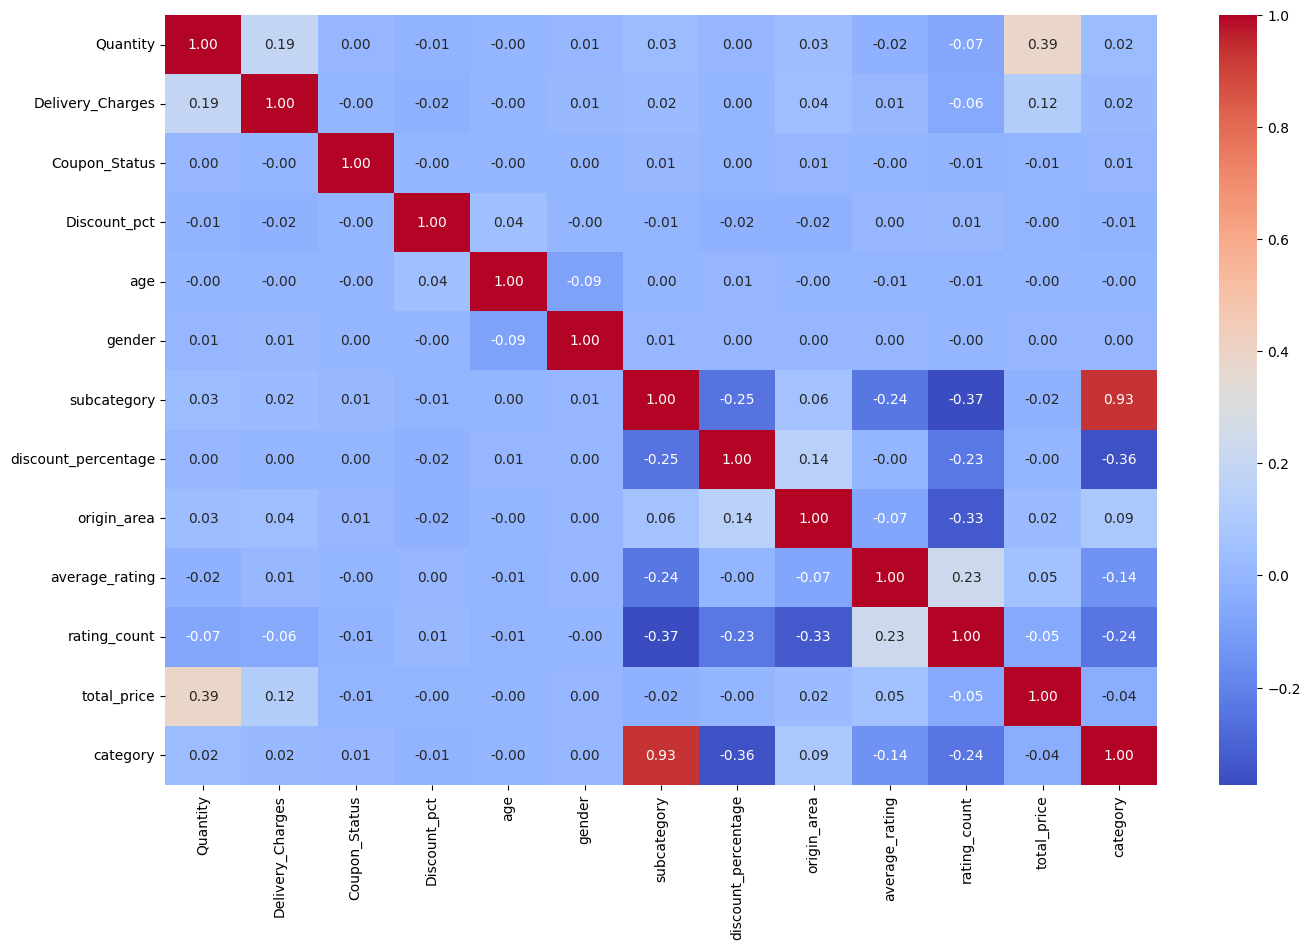

In [41]:
correlation_matrix = encoded_sales.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Except for category and subcategory which are obiously related, none of the features are highly correlated.

## Part 2: Analyse purchasing behaviour

#### RFM (Recency, Frequency, Monetary) Analysis

In [42]:
historical_sales['total_price'] = historical_sales['total_price'].astype(float)

# Set a dummy reference date for recency calculations
reference_date = pd.to_datetime('2024-10-05')

rfm = historical_sales.groupby('user_id').agg({
    'date': lambda x: (reference_date - x.max()).days,  
    'transaction_id': 'count',                         
    'total_price': 'sum'                             
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
user_id,,,
12346,1847,2,1216.145
12347,1799,60,13458.201
12348,1813,23,29423.237
12350,1757,17,12106.145
12356,1847,36,6645.129


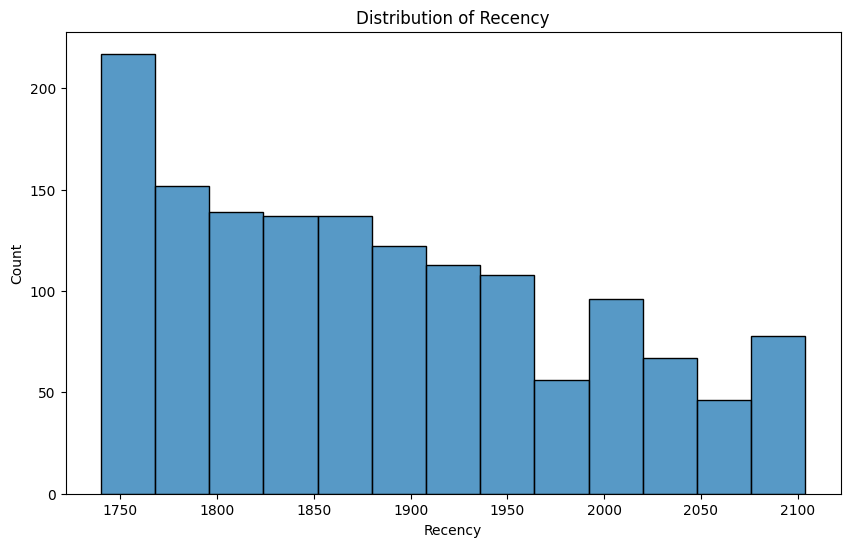

In [43]:
# Distribution of Recency
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Recency')
plt.title("Distribution of Recency")
plt.show()

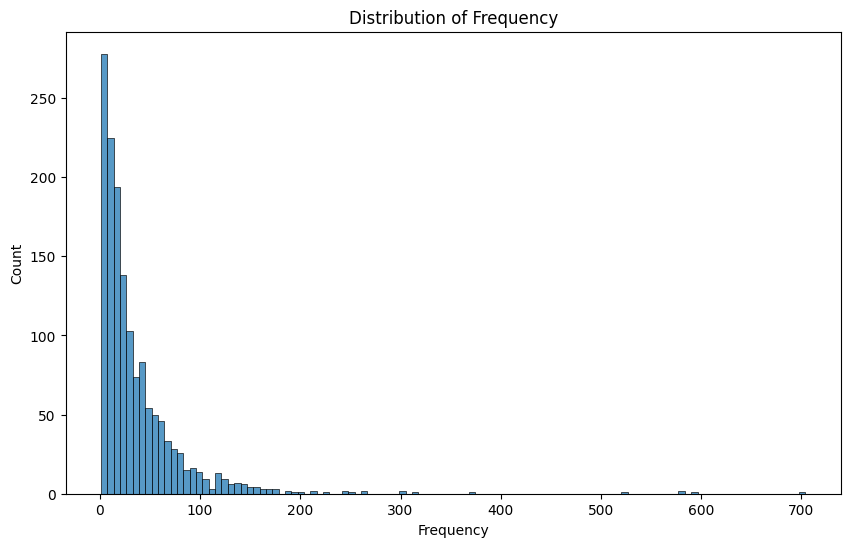

In [44]:
# Distribution of Frequency
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Frequency')
plt.title("Distribution of Frequency")
plt.show()

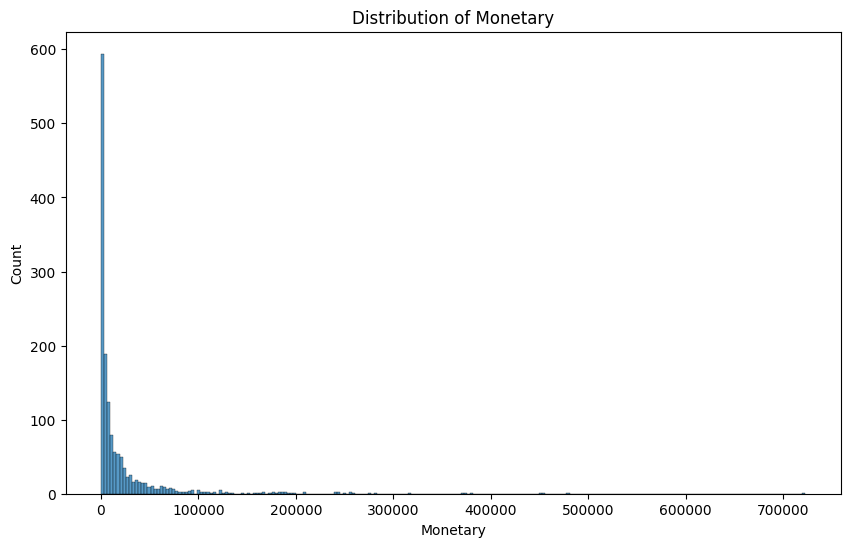

In [45]:
# Distribution of Monetary
plt.figure(figsize=(10,6))
sns.histplot(data=rfm, x='Monetary')
plt.title("Distribution of Monetary")
plt.show()

In [46]:
# Rank each customer for Recency, Frequency, and Monetary
rfm['Recency_rank'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['Frequency_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_rank'] = pd.qcut(rfm['Monetary'].astype(float), 5, labels=[1, 2, 3, 4, 5])  # Ensuring Monetary is float

rfm['RFM_Score'] = rfm['Recency_rank'].astype(int) + rfm['Frequency_rank'].astype(int) + rfm['Monetary_rank'].astype(int)

# Customer segmentation based on RFM score
rfm['Segment'] = pd.cut(rfm['RFM_Score'], bins=[2, 5, 8, 11, 15], labels=['Low', 'Medium', 'High', 'Top'])

rfm.head()

,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,RFM_Score,Segment
user_id,,,,,,,,
12346,1847,2,1216.145,3,1,2,6,Medium
12347,1799,60,13458.201,4,5,4,13,Top
12348,1813,23,29423.237,4,3,5,12,Top
12350,1757,17,12106.145,5,3,4,12,Top
12356,1847,36,6645.129,3,4,3,10,High


Each customer was assigned a rank based from 1 - 5 for Recency, Frequency and Monetary based on their last purchase, total number of purchases and total amount spent respectively.  
The total of their ranks will result in their RFM score.
The RFM scores were split into Low (2-5), Medium (6-8), High (9-11) and Top (12-15).  
This means customers with higher RFM scores, who are frequent buyers, have high spending, and recently made purchases, will fall into the Top segment, while those with lower RFM scores, reflecting infrequent, low-value purchases or long inactivity, will fall into the Low segment.

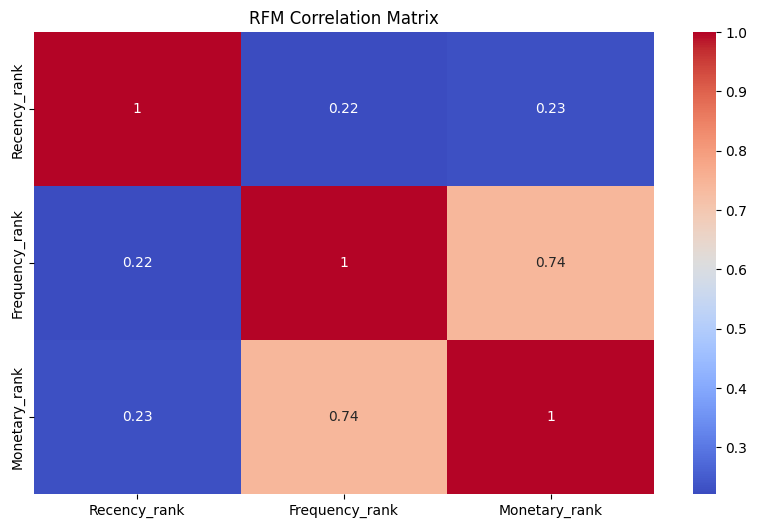

In [47]:
rfm_corr = rfm[['Recency_rank', 'Frequency_rank', 'Monetary_rank']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm')
plt.title('RFM Correlation Matrix')
plt.show()


We see that Frequency and Monetary has a relatively strong positive correlation of 0.74.  
This implies that customers who make purchases more frequently also tend to spend more money (higher monetary value) and could mean that customers with frequent purchases are likely higher-value customers, making them important for retention efforts.

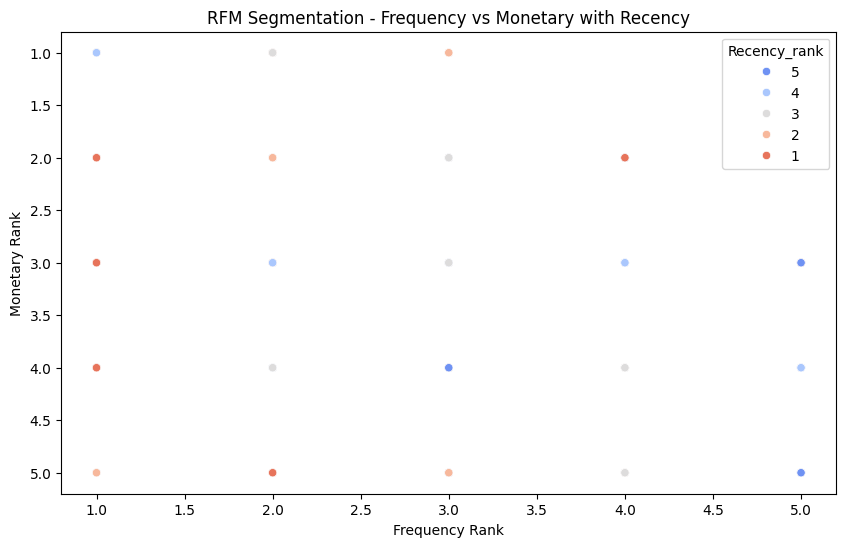

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency_rank', y='Monetary_rank', hue='Recency_rank', data=rfm, palette='coolwarm')
plt.title('RFM Segmentation - Frequency vs Monetary with Recency')
plt.xlabel('Frequency Rank')
plt.ylabel('Monetary Rank')
plt.show()


There is a general trend where customers recency rank increases as their frequency and monetary rank increases as well. This trend reflects that loyal, high-spending customers are also the most recent ones to engage with the company, making them valuable to the business.

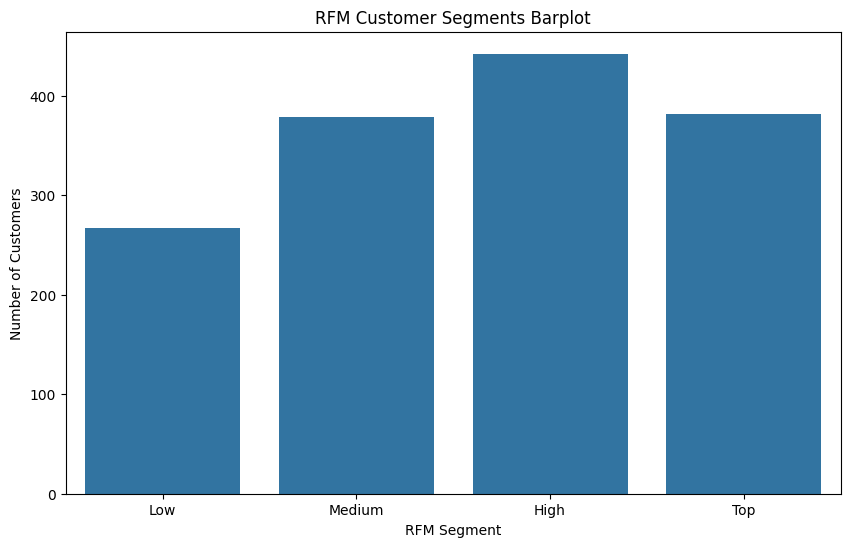

In [49]:
# rfm['RFM_Segment'] = rfm['Recency_rank'].astype(str) + rfm['Frequency_rank'].astype(str) + rfm['Monetary_rank'].astype(str)

rfm_segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=rfm_segment_counts.index, y=rfm_segment_counts.values)
plt.title('RFM Customer Segments Barplot')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.show()


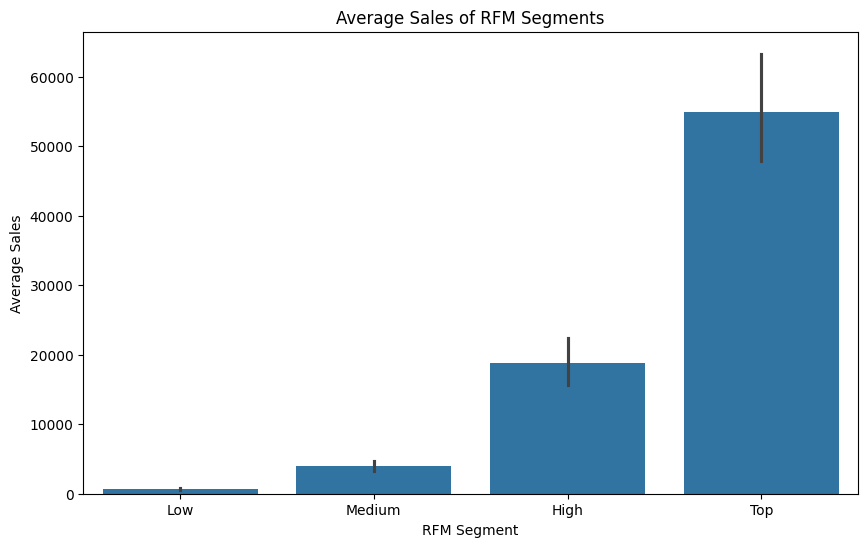

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(x=rfm['Segment'], y=rfm['Monetary'])
plt.title('Average Sales of RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Average Sales')
plt.show()

We see that most of the customers fall under the High and Top segments.  Considering that these customers likely drive a significant portion of revenue as seen by their average sales, it would be wise to focus on maintaining engagement and offering exclusive deals or loyalty programs to sustain their high purchase rates.


#### Customer Lifetime Value Model (CLTV)

CLTV is a metric which provides insight into how much revenue a customer might bring in over time and allows us to predict how much revenue a customer will contribute over the average estimated length of time that they are a customer.  

The formula we will use is CLTV = ((Average Order Value x Purchase Frequency) / Churn Rate) x Profit margin 

In [51]:
# Aggregate data at the customer level
cltv = historical_sales.groupby('user_id').agg({
    'transaction_id': 'nunique',           # Number of orders (Frequency)
    'total_price': 'sum',                  # Total revenue (Monetary)           
    'product_id': 'nunique',               # Number of unique products purchased
    'date': 'max'
}).reset_index()
cltv.columns = ['user_id', 'total_orders', 'total_revenue', 'unique_products', 'last_purchase_date']

In [52]:
# Calculate average order value (AOV)
# The AOV is the ratio of the total revenue and the total number of orders. It represents the amount of revenue 
# a customer spends on an order.
cltv['AOV'] = cltv['total_revenue'] / cltv['total_orders']

In [53]:
# Calculate Purchase frequency 
# Purchase frequency is the ratio of the total number of orders and the total number of customers. It represents the
# average number of orders placed by each customer in a year in this case.

cltv['purchase_frequency'] = cltv['total_orders']/(cltv.shape[0])

In [54]:
cltv['customer_value'] = cltv['purchase_frequency'] * cltv['AOV']

In [55]:
repeat_rate = cltv[cltv["total_orders"] > 1].shape[0] / cltv.shape[0]
churn_rate = 1 - repeat_rate

In [56]:
cltv["profit_margin"] = cltv["total_revenue"] * 0.20

In [57]:
cltv["cltv"] = cltv["customer_value"] / churn_rate * cltv["profit_margin"]
cltv.head()

,user_id,total_orders,total_revenue,unique_products,last_purchase_date,AOV,purchase_frequency,customer_value,profit_margin,cltv
0,12346,1,1216.145,2,2019-09-15,1216.145000,0.000681,0.828437,243.2290,2.366414e+03
1,12347,31,13458.201,33,2019-11-02,434.135516,0.021117,9.167712,2691.6402,2.897971e+05
2,12348,8,29423.237,16,2019-10-19,3677.904625,0.005450,20.043077,5884.6474,1.385163e+06
3,12350,11,12106.145,7,2019-12-14,1100.558636,0.007493,8.246693,2421.2290,2.344940e+05
4,12356,13,6645.129,25,2019-09-15,511.163769,0.008856,4.526655,1329.0258,7.065238e+04


In [58]:
cltv.sort_values(by="cltv", ascending=False)

cltv["quantile_segment"] = pd.qcut(cltv["cltv"], 4, labels=["Low", "Medium", "High", "Top"])
cltv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             1468 non-null   int64         
 1   total_orders        1468 non-null   int64         
 2   total_revenue       1468 non-null   float64       
 3   unique_products     1468 non-null   int64         
 4   last_purchase_date  1468 non-null   datetime64[ns]
 5   AOV                 1468 non-null   float64       
 6   purchase_frequency  1468 non-null   float64       
 7   customer_value      1468 non-null   float64       
 8   profit_margin       1468 non-null   float64       
 9   cltv                1468 non-null   float64       
 10  quantile_segment    1468 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6), int64(3)
memory usage: 116.4 KB


### Segment cltv by quantiles

In [59]:
cltv_quantiles = cltv.copy().drop('last_purchase_date', axis='columns').groupby("quantile_segment").agg({"sum", "mean", "count"})
cltv_quantiles

user_id                total_orders               \
                          mean count      sum         mean count    sum   
quantile_segment                                                          
Low               15301.136240   367  5615517     4.321526   367   1586   
Medium            15322.054496   367  5623194    10.735695   367   3940   
High              15329.866485   367  5626061    19.798365   367   7266   
Top               15304.487738   367  5616747    37.708447   367  13839   

                 total_revenue                     unique_products  ...  \
                          mean count           sum            mean  ...   
quantile_segment                                                    ...   
Low                 417.452698   367  1.532051e+05        5.397820  ...   
Medium             2865.154019   367  1.051512e+06       12.558583  ...   
High              10763.243635   367  3.950110e+06       20.307902  ...   
Top               70219.611117   367  2.577060e+07       30.084469  ...   

                 purchase_frequency customer_value                      \
                                sum           mean count           sum   
quantile_segment                                                         
Low                        1.080381       0.284368   367    104.363174   
Medium                     2.683924       1.951740   367    716.288505   
High                       4.949591       7.331910   367   2690.810909   
Top                        9.427112      47.833523   367  17554.902779   

                 profit_margin                              cltv        \
                          mean count           sum          mean count   
quantile_segment                                                         
Low                  83.490540   367  3.064103e+04  4.597271e+02   367   
Medium              573.030804   367  2.103023e+05  1.560440e+04   367   
High               2152.648727   367  7.900221e+05  2.115114e+05   367   
Top               14043.922223   367  5.154119e+06  1.778318e+07   367   

                                
                           sum  
quantile_segment                
Low               1.687199e+05  
Medium            5.726814e+06  
High              7.762469e+07  
Top               6.526426e+09  

[4 rows x 27 columns]

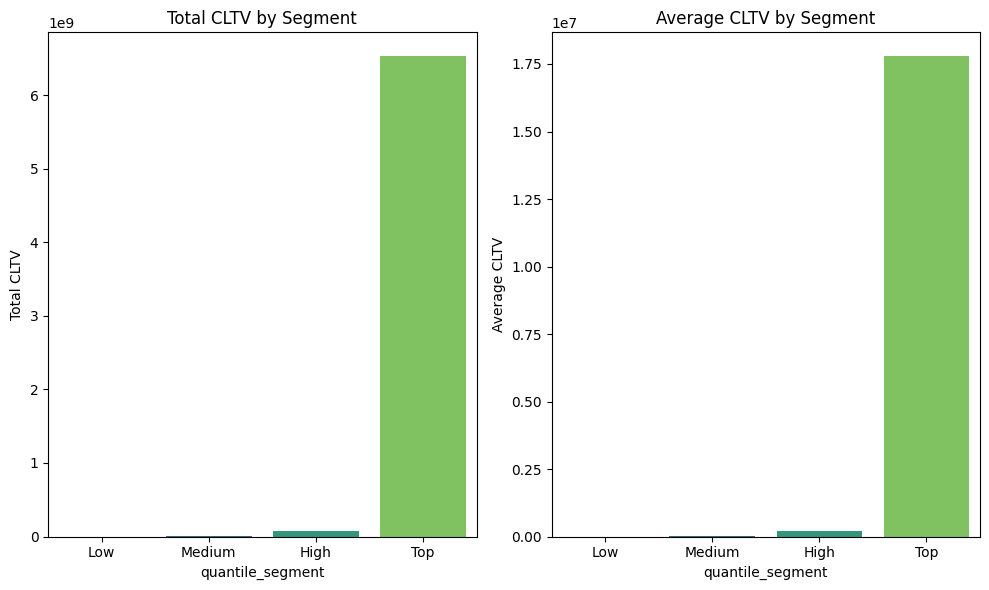

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.barplot(x=cltv_quantiles.index, y=cltv_quantiles['cltv']['sum'], ax=ax[0], palette="viridis")
ax[0].set_title("Total CLTV by Segment")
ax[0].set_ylabel("Total CLTV")
sns.barplot(x=cltv_quantiles.index, y=cltv_quantiles['cltv']['mean'], ax=ax[1], palette="viridis")
ax[1].set_title("Average CLTV by Segment")
ax[1].set_ylabel("Average CLTV")
plt.tight_layout()
plt.show()

### Segment CLTV by fixed thresholds

In [61]:
# Define the fixed CLTV thresholds
bins = [0, 500, 10000, 500000, float('inf')]  
labels = ["Low", "Medium", "High", "Top"]

# Segment CLTV based on specified thresholds
cltv["bin_segment"] = pd.cut(cltv["cltv"], bins=bins, labels=labels, right=False)

# Sort by segment if needed
cltv = cltv.sort_values(by="bin_segment", ascending=False)

# Display the results
cltv.head()


,user_id,total_orders,total_revenue,unique_products,last_purchase_date,AOV,purchase_frequency,customer_value,profit_margin,cltv,quantile_segment,bin_segment
1467,18283,53,18268.110,41,2019-10-10,344.681321,0.036104,12.444217,3653.6220,5.339581e+05,High,Top
304,13534,23,38868.759,28,2019-11-14,1689.946043,0.015668,26.477356,7773.7518,2.417249e+06,Top,Top
812,15615,20,19302.228,28,2019-08-30,965.111400,0.013624,13.148657,3860.4456,5.961216e+05,Top,Top
806,15601,88,64905.180,52,2019-11-14,737.558864,0.059946,44.213338,12981.0360,6.740292e+06,Top,Top
805,15596,18,31986.346,28,2019-11-08,1777.019222,0.012262,21.789064,6397.2692,1.637002e+06,Top,Top


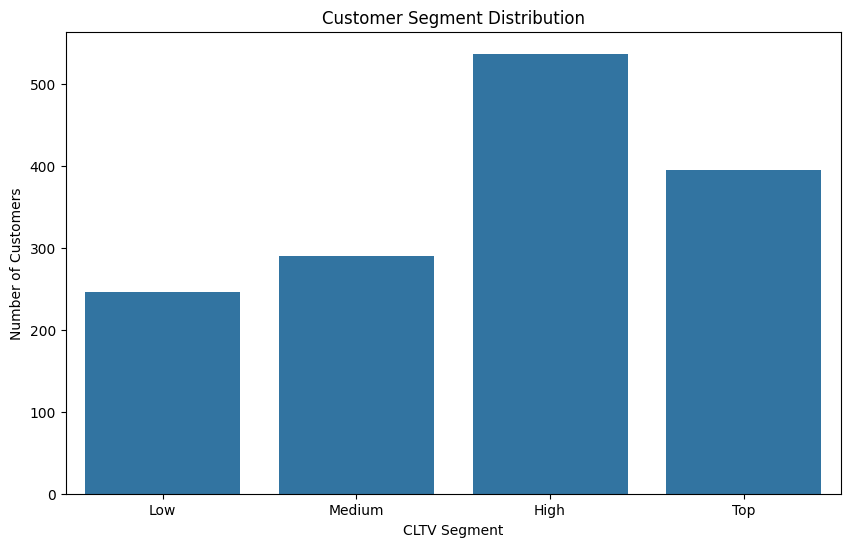

In [62]:
cltv_binned = cltv["bin_segment"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cltv_binned.index, y=cltv_binned.values)
plt.title("Customer Segment Distribution")
plt.xlabel("CLTV Segment")
plt.ylabel("Number of Customers")
plt.show()

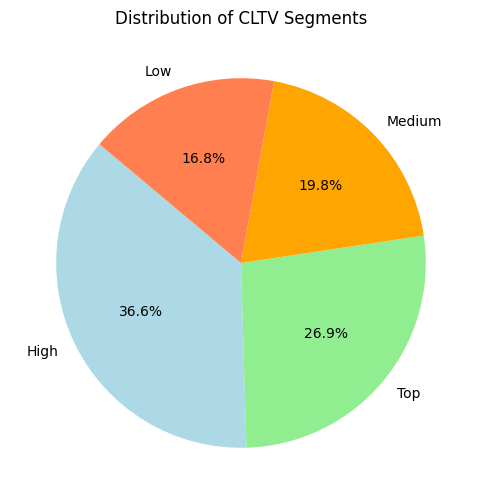

In [63]:
plt.figure(figsize=(10, 6))
plt.pie(cltv_binned, labels=cltv_binned.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'orange', 'coral'])
plt.title("Distribution of CLTV Segments")
plt.show()

Majority of customers have a high CLTV of at least 10,000 USD with 26.9% of customers having a very high CLTV of at least half a million USD.

### CLTV Prediction Model  

A Customer Lifetime Value (CLTV) prediction model estimates the total future revenue or profit a business can expect from a customer over the entire duration of their relationship. By analyzing historical data such as purchase frequency, recency, and average order value, the model predicts how often a customer will buy and how much they will spend in the future.

In [64]:
# Aggregate data at the customer level
cltv_prediction = cltv.copy()[['user_id', 'total_orders', 'total_revenue', 'cltv', 'last_purchase_date']]
today_date = dt.datetime(2020, 1, 1)
cltv_prediction['recency'] = ( today_date - cltv_prediction['last_purchase_date']).dt.days + 1

cltv_prediction.columns = ['user_id', 'frequency', 'monetary', 'cltv', 'last_purchased_date', 'recency']
cltv_prediction.sort_values(by='user_id')

,user_id,frequency,monetary,cltv,last_purchased_date,recency
0,12346,1,1216.145,2.366414e+03,2019-09-15,109
1,12347,31,13458.201,2.897971e+05,2019-11-02,61
2,12348,8,29423.237,1.385163e+06,2019-10-19,75
3,12350,11,12106.145,2.344940e+05,2019-12-14,19
4,12356,13,6645.129,7.065238e+04,2019-09-15,109
...,...,...,...,...,...,...
1463,18259,3,2210.260,7.816399e+03,2019-04-05,272
1464,18260,19,5444.008,4.741956e+04,2019-10-05,89
1465,18269,2,846.995,1.147841e+03,2019-06-20,196
1466,18277,1,110.160,1.941636e+01,2019-10-23,71


In [79]:
cltv_prediction = cltv_prediction[cltv_prediction['user_id']!=13113]

In [82]:
# Final feature set for model
features = cltv_prediction[['frequency', 'monetary', 'recency']]
target = cltv_prediction['cltv']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest Model

In [85]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

In [86]:
# Random Forest Evaluation
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 15403514197383.102
R-squared: 0.9701954997208961


The R-squared value of 0.97 indicates that the random forest model is able to predict closely to the actual cltv values, and only 3% of the variation in the target variable is due to factors not captured by the model.

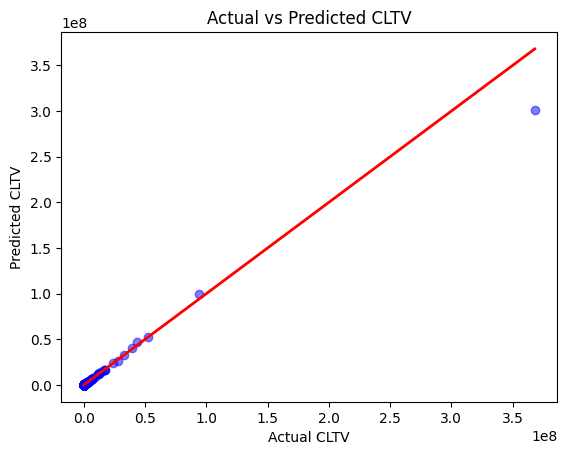

In [87]:
# Scatter plot of Actual vs Predicted CLTV for RF
plt.scatter(y_test, y_pred_rf, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2) 
plt.xlabel('Actual CLTV')
plt.ylabel('Predicted CLTV')
plt.title('Actual vs Predicted CLTV')
plt.show()


Generally, we see that the predicted blue points follow the values of the red line, with a few cases of over and under prediction especially as the CLTV increases.

In [71]:
cltv_prediction

,user_id,frequency,monetary,cltv,last_purchased_date,recency
1467,18283,53,18268.110,5.339581e+05,2019-10-10,84
304,13534,23,38868.759,2.417249e+06,2019-11-14,49
812,15615,20,19302.228,5.961216e+05,2019-08-30,125
806,15601,88,64905.180,6.740292e+06,2019-11-14,49
805,15596,18,31986.346,1.637002e+06,2019-11-08,55
...,...,...,...,...,...,...
920,16086,5,227.089,8.251106e+01,2019-03-22,286
206,13094,4,389.746,2.430431e+02,2019-07-31,155
922,16098,5,419.808,2.819820e+02,2019-01-02,365
923,16109,3,320.380,1.642294e+02,2019-12-24,9


In [95]:
cltv_prediction['predicted_CLTV'] = rf_model.predict(scaler.transform(features))

# Set the threshold for VIP customers (e.g., top 10% by predicted CLTV)
threshold = cltv_prediction['predicted_CLTV'].quantile(0.90)

# Mark VIP customers
cltv_prediction['VIP'] = cltv_prediction['predicted_CLTV'] >= threshold

# View VIP customers
vip_customers = cltv_prediction[cltv_prediction['VIP'] == True]

print("Number of VIP customers:", len(vip_customers))
print(vip_customers[['user_id', 'cltv', 'predicted_CLTV']])

Number of VIP customers: 147
      user_id          cltv  predicted_CLTV
806     15601  6.740292e+06    6.753579e+06
1151    17064  4.598582e+06    4.604362e+06
572     14646  2.002750e+07    1.976966e+07
573     14653  1.864274e+07    1.861320e+07
292     13488  1.272578e+08    1.247576e+08
...       ...           ...             ...
746     15351  4.550519e+07    4.612466e+07
135     12826  6.177127e+06    6.160212e+06
1292    17602  6.738263e+06    6.766112e+06
1312    17675  1.657416e+07    1.649324e+07
1295    17611  6.444303e+06    6.477959e+06

[147 rows x 3 columns]


/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_28532/3795535091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cltv_prediction['predicted_CLTV'] = rf_model.predict(scaler.transform(features))
/var/folders/gd/v8v96pt94wl6b52w5qldf23m0000gn/T/ipykernel_28532/3795535091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cltv_prediction['VIP'] = cltv_prediction['predicted_CLTV'] >= threshold


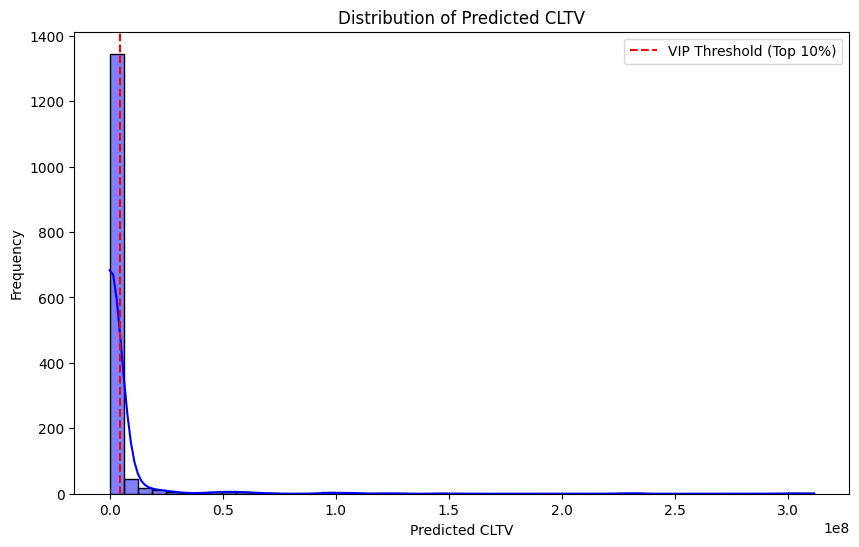

In [91]:
plt.figure(figsize=(10, 6))
sns.histplot(cltv_prediction['predicted_CLTV'], bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label=f'VIP Threshold (Top 10%)')
plt.title('Distribution of Predicted CLTV')
plt.xlabel('Predicted CLTV')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [92]:
top_customers = vip_customers[['user_id', 'cltv', 'predicted_CLTV']].sort_values(by='cltv', ascending=False)
top_customers

,user_id,cltv,predicted_CLTV
200,13081,3.680615e+08,3.011167e+08
118,12748,3.298184e+08,3.117953e+08
1355,17841,3.230054e+08,3.003214e+08
567,14621,2.309483e+08,2.298557e+08
689,15144,2.242773e+08,2.266309e+08
...,...,...,...
603,14744,4.642016e+06,4.626277e+06
1151,17064,4.598582e+06,4.604362e+06
853,15820,4.546659e+06,4.566408e+06
794,15549,4.424062e+06,4.396670e+06


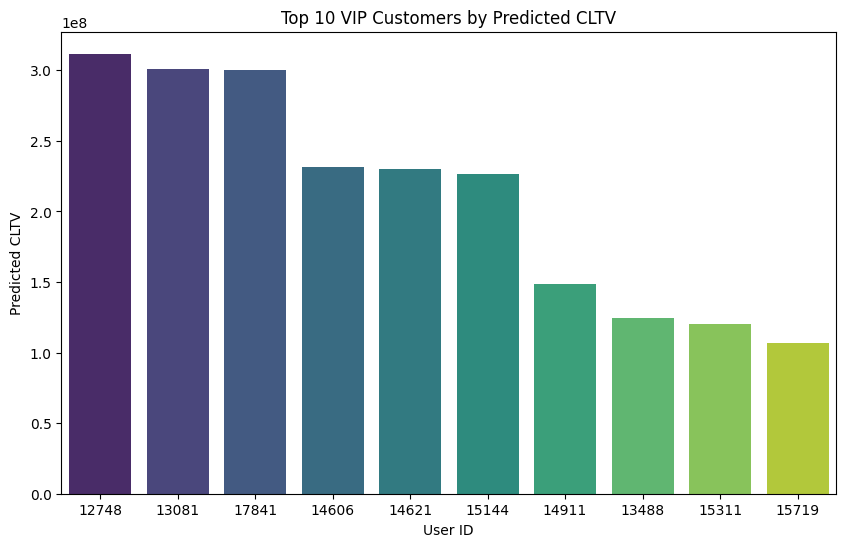

In [93]:
top_vip_customers = vip_customers[['user_id', 'predicted_CLTV']].sort_values(by='predicted_CLTV', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='user_id', y='predicted_CLTV', data=top_vip_customers, 
            palette='viridis', order=top_vip_customers.sort_values('predicted_CLTV', ascending=False)['user_id'])
plt.title('Top 10 VIP Customers by Predicted CLTV')
plt.xlabel('User ID')
plt.ylabel('Predicted CLTV')
plt.show()

These top 10 customers represent the most valuable segment of Amazon's ecommerce customer base, as identified by their high CLTV. These customers contribute a significant portion of the business’s revenue and profitability due to their frequent purchases, higher average order values, and loyalty and it would be extremely beneficial to the corporation to retain these individuals.